In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import tensorflow as tf
import numpy as np

IMAGES_WITH = 128
IMAGES_HEIGHT = 128

# data from here https://www.kaggle.com/datasets/franciscoescobar/satellite-images-of-water-bodies

images_path = "/content/drive/MyDrive/Data/Water Bodies Dataset/Images"
masks_path = "/content/drive/MyDrive/Data/Water Bodies Dataset/Masks"

images = []
masks = []
for path in os.listdir(images_path):
  image = tf.io.read_file(images_path + "/" + path)
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.resize(image, (IMAGES_HEIGHT, IMAGES_WITH), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  image = tf.math.divide(image, 255)
  images.append(image)

  mask = tf.io.read_file(masks_path + "/" + path)
  mask = tf.image.decode_jpeg(mask, channels=1)
  mask = tf.image.resize(mask, (IMAGES_HEIGHT, IMAGES_WITH), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  mask = tf.where(mask > 127, 1, 0)
  masks.append(mask)

images = np.array(images)
masks = np.array(masks)

print("dataset size")
print(images.shape)
print(masks.shape)

split = 0.8

images_train = images[:int(images.shape[0]*split)]
masks_train = masks[:int(masks.shape[0]*split)]

print("train size")
print(images_train.shape)
print(masks_train.shape)

images_val = images[int(images.shape[0]*split):]
masks_val = masks[int(masks.shape[0]*split):]

print("validation size")
print(images_val.shape)
print(masks_val.shape)

dataset size
(2841, 128, 128, 3)
(2841, 128, 128, 1)
train size
(2272, 128, 128, 3)
(2272, 128, 128, 1)
validation size
(569, 128, 128, 3)
(569, 128, 128, 1)


In [4]:
def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):

    conv = tf.keras.layers.Conv2D(n_filters, # Number of filters
                  3,   # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(inputs)

    conv = tf.keras.layers.Conv2D(n_filters, # Number of filters
                  3,   # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(conv)

    if dropout_prob > 0:
        conv = tf.keras.layers.Dropout(dropout_prob)(conv)

    if max_pooling:
        next_layer = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(conv)
    else:
        next_layer = conv

    skip_connection = conv

    return next_layer, skip_connection

def upsampling_block(expansive_input, contractive_input, n_filters=32):

    up = tf.keras.layers.Conv2DTranspose(
                 n_filters,    # number of filters
                 3,    # Kernel size
                 strides=(2,2),
                 padding='same')(expansive_input)

    merge = tf.keras.layers.concatenate([up, contractive_input], axis=3)

    conv = tf.keras.layers.Conv2D(n_filters,   # Number of filters
                 3,     # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(merge)

    conv = tf.keras.layers.Conv2D(n_filters,  # Number of filters
                 3,   # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(conv)

    return conv

def unet_model(input_size=(128, 128, 3), n_filters=32):

    inputs = tf.keras.layers.Input(input_size)

    cblock1 = conv_block(inputs, n_filters)
    cblock2 = conv_block(cblock1[0], 2*n_filters)
    cblock3 = conv_block(cblock2[0], 2**2*n_filters)
    cblock4 = conv_block(cblock3[0], 2**3*n_filters, dropout_prob=0.3)
    cblock5 = conv_block(cblock4[0], 2**4*n_filters, dropout_prob=0.3, max_pooling=False)

    ublock6 = upsampling_block(cblock5[0], cblock4[1],  2**3*n_filters)
    ublock7 = upsampling_block(ublock6, cblock3[1],  2**2*n_filters)
    ublock8 = upsampling_block(ublock7, cblock2[1],  2*n_filters)
    ublock9 = upsampling_block(ublock8, cblock1[1],  n_filters)

    conv9 = tf.keras.layers.Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock9)

    conv10 = tf.keras.layers.Conv2D(1, 1, padding='same',activation='sigmoid')(conv9)

    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

model = unet_model(input_size=(IMAGES_HEIGHT, IMAGES_WITH, 3), n_filters=32)

model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])

#tf.keras.utils.plot_model(model, show_shapes=True)

In [5]:
history = model.fit(images_train, masks_train, epochs=10, validation_data=(images_val, masks_val))

Epoch 1/10
71/71 [==============================] - 303s 4s/step - loss: 0.5890 - accuracy: 0.7403 - val_loss: 0.5125 - val_accuracy: 0.7523
Epoch 2/10
71/71 [==============================] - 321s 5s/step - loss: 0.4894 - accuracy: 0.7761 - val_loss: 0.4692 - val_accuracy: 0.7923
Epoch 3/10
71/71 [==============================] - 426s 6s/step - loss: 0.4641 - accuracy: 0.7932 - val_loss: 0.4475 - val_accuracy: 0.8112
Epoch 4/10
71/71 [==============================] - 415s 6s/step - loss: 0.4478 - accuracy: 0.8043 - val_loss: 0.4070 - val_accuracy: 0.8315
Epoch 5/10
71/71 [==============================] - 335s 5s/step - loss: 0.4057 - accuracy: 0.8275 - val_loss: 0.4518 - val_accuracy: 0.8099
Epoch 6/10
71/71 [==============================] - 391s 6s/step - loss: 0.4040 - accuracy: 0.8286 - val_loss: 0.3466 - val_accuracy: 0.8628
Epoch 7/10
71/71 [==============================] - 442s 6s/step - loss: 0.3760 - accuracy: 0.8429 - val_loss: 0.3881 - val_accuracy: 0.8564
Epoch 8/10
71

1/1 [==============================] - 0s 60ms/step


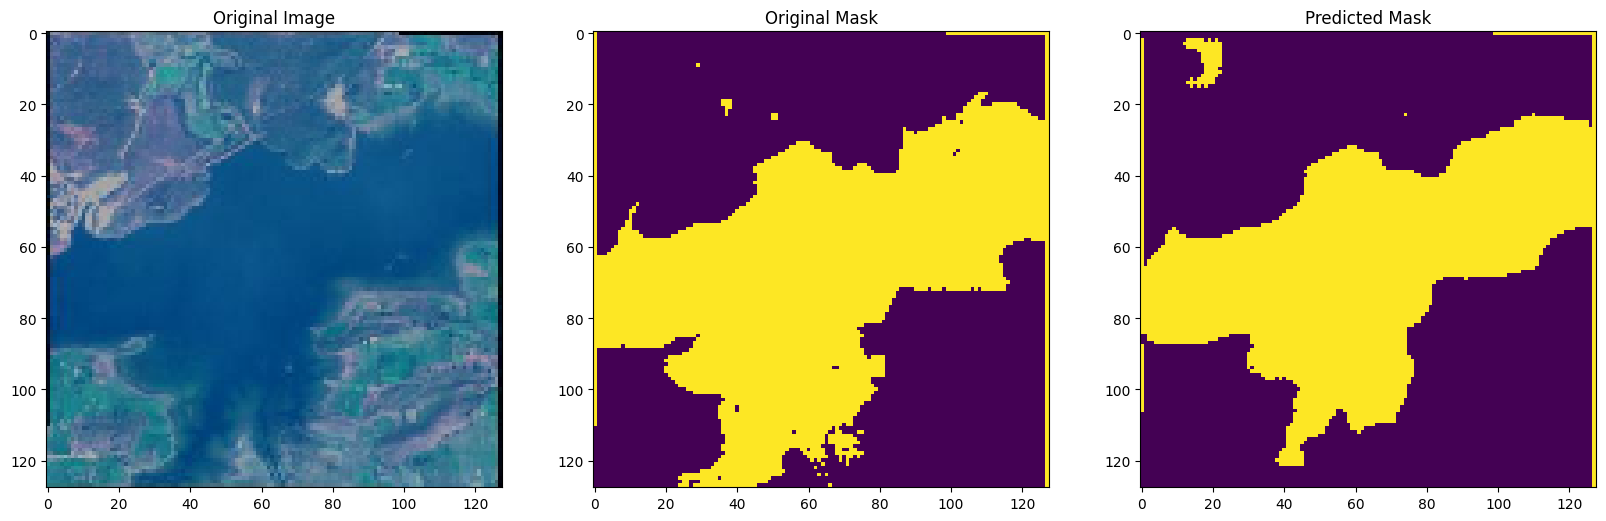

In [14]:
import random
import matplotlib.pyplot as plt

figure, axes = plt.subplots(1, 3, figsize=(20,20))

rand_num = random.randint(0, images_val.shape[0])

original_img = images_val[rand_num]
axes[0].imshow(original_img)
axes[0].title.set_text('Original Image')

original_mask = masks_val[rand_num]
axes[1].imshow(original_mask)
axes[1].title.set_text('Original Mask')

predicted_mask = model.predict(np.array([original_img]))[0]
predicted_mask = tf.where(predicted_mask > 0.5, 1, 0)
axes[2].imshow(predicted_mask)
axes[2].title.set_text('Predicted Mask')